# Clasificación reseñas de cine

In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

# Carga dataset IMDB

In [158]:
# Cargar dataset IMDB
max_words = 5000  # Tamaño del vocabulario
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)

# Definición secuencias

In [159]:
# Definir longitud máxima de las secuencias
max_len = 200
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Definición modelo

In [160]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    Conv1D(128, 5, activation='relu'),  
    MaxPooling1D(pool_size=4),
    # LSTM con regularización más suave
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),  
    Dense(1, activation='sigmoid')  # Regularización L2 más suave
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento modelo

In [161]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')
# Entrenar el modelo (puedes ajustar el número de épocas según sea necesario)
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[callback])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.3669 - accuracy: 0.8285 - val_loss: 0.2835 - val_accuracy: 0.8816
Epoch 2/10
25000/25000 [==============================] - 53s 2ms/sample - loss: 0.2169 - accuracy: 0.9166 - val_loss: 0.3057 - val_accuracy: 0.8702


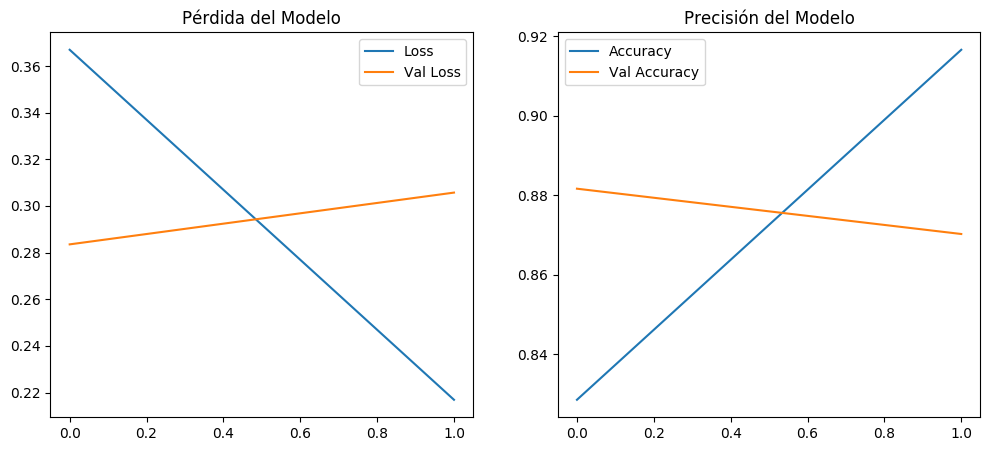

In [162]:
# Visualización de la pérdida y precisión
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Pérdida del Modelo")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Precisión del Modelo")
plt.show()

# Test

## Tokenizador. El dataset de IMDB ya trae el contenido tokenizado así que tenemos que cargar el mismo Tokenizador usado por IMDB

In [163]:
# Obtener el índice de palabras del dataset IMDB
word_index = imdb.get_word_index()
# Crear el tokenizador con el mismo vocabulario
tokenizer = Tokenizer(num_words=max_words)
tokenizer.word_index = {k: (v + 3) for k, v in word_index.items()}  # Ajuste de índices
tokenizer.word_index["<PAD>"] = 0
tokenizer.word_index["<START>"] = 1
tokenizer.word_index["<UNK>"] = 2  # Desconocidas
tokenizer.word_index["<UNUSED>"] = 3

## Función clasificadora de reseñas positivas (1) y negativas (0)

In [164]:
def detectar_anomalia(texto):
    seq = tokenizer.texts_to_sequences([texto])
    seq_padded = pad_sequences(seq, maxlen=max_len, padding='post')
    prediccion = model.predict(seq_padded)[0,0]
    
    print(f"Texto: {texto}\nProbabilidad de anomalía: {prediccion:.4f}")
    if prediccion > 0.5:
        print("¡Anomalía detectada!\n")
    else:
        print("Texto normal.\n")

## Reseñas a clasificar

In [165]:
reseñas_positivas_ingles = [
    "Amazing movie, the acting is brilliant and the story very emotional. It kept me hooked from beginning to end. I would definitely watch it again.",
    "A masterpiece. The special effects are impressive and the soundtrack is perfect. I totally recommend it to anyone who loves cinema.",
    "I loved every moment, a well-told story and endearing characters. Great development and an epic ending that left me speechless.",
    "Funny, exciting and with a great message. The chemistry between the actors is excellent, and the script is full of memorable moments.",
    "Perfect combination of action and drama. I was pleasantly surprised, I expected less but it turned out to be one of the best movies I've seen."
]

reseñas_negativas_ingles = [
    "Terrible. The script is boring, the characters flat and the plot makes no sense. It was hard for me to finish it, a big disappointment.",
    "The worst movie of the year. Bad acting, poor visual effects and a predictable plot. I don't understand how people enjoy it.",
    "Nothing remarkable, full of clichés and unnecessary moments. I wasted two hours of my life on this. I don't recommend it at all.",
    "It tried to be deep but failed. Slow development and an absurd ending. I really expected something better, but it left me with a feeling of emptiness.",
    "I don't understand the good reviews. I found it forced and soulless. Not even the actors could save it. A waste of time and money."
]

## Clasificación de reseñas Positivas

In [166]:
for res_positiva in reseñas_positivas_ingles:
    detectar_anomalia(res_positiva)

Texto: Amazing movie, the acting is brilliant and the story very emotional. It kept me hooked from beginning to end. I would definitely watch it again.
Probabilidad de anomalía: 0.9758
¡Anomalía detectada!

Texto: A masterpiece. The special effects are impressive and the soundtrack is perfect. I totally recommend it to anyone who loves cinema.
Probabilidad de anomalía: 0.9273
¡Anomalía detectada!

Texto: I loved every moment, a well-told story and endearing characters. Great development and an epic ending that left me speechless.
Probabilidad de anomalía: 0.8614
¡Anomalía detectada!

Texto: Funny, exciting and with a great message. The chemistry between the actors is excellent, and the script is full of memorable moments.
Probabilidad de anomalía: 0.9512
¡Anomalía detectada!

Texto: Perfect combination of action and drama. I was pleasantly surprised, I expected less but it turned out to be one of the best movies I've seen.
Probabilidad de anomalía: 0.9736
¡Anomalía detectada!



## Clasificación de reseñas Negativas

In [167]:
for res_negativa in reseñas_negativas_ingles:
    detectar_anomalia(res_negativa)

Texto: Terrible. The script is boring, the characters flat and the plot makes no sense. It was hard for me to finish it, a big disappointment.
Probabilidad de anomalía: 0.0150
Texto normal.

Texto: The worst movie of the year. Bad acting, poor visual effects and a predictable plot. I don't understand how people enjoy it.
Probabilidad de anomalía: 0.0419
Texto normal.

Texto: Nothing remarkable, full of clichés and unnecessary moments. I wasted two hours of my life on this. I don't recommend it at all.
Probabilidad de anomalía: 0.1514
Texto normal.

Texto: It tried to be deep but failed. Slow development and an absurd ending. I really expected something better, but it left me with a feeling of emptiness.
Probabilidad de anomalía: 0.0353
Texto normal.

Texto: I don't understand the good reviews. I found it forced and soulless. Not even the actors could save it. A waste of time and money.
Probabilidad de anomalía: 0.0430
Texto normal.

